In [1]:
cd ../

/home/wakaizumi/program/M1/道路ネットワーク


In [2]:
#基本ライブラリ
import csv
import math
import random
import numpy as np
import numpy.random as random
import pandas as pd
from pandas import Series,DataFrame
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
#地図描画
import folium
import networkx as nx
from IPython.display import SVG, display
import collections
import seaborn as sns
#Bokehを利用
import datetime
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import HoverTool
from bokeh.palettes import Pastel1_3    # カラーパレット
from bokeh.transform import factor_cmap # 
from bokeh.io import output_notebook, push_notebook, export_png
import ipywidgets as widgets
#その他
import copy
import pickle
import statistics
import sys
#自作ライブラリ
from def1 import *
from def2_1 import *
from def3 import *
from agent3 import *
%matplotlib inline
%precision 6

/home/wakaizumi/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/home/wakaizumi/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


'%.6f'

In [3]:
node_df = pd.read_csv('/home/wakaizumi/data/opendataTokyo/mapdata/東京駅周辺/node.csv')
link_df = pd.read_csv('/home/wakaizumi/data/opendataTokyo/mapdata/東京駅周辺/link.csv')
node_df['name'] = 'node'
#特殊なポイント
station1 = 1897;station2 = 2416;station3 = 2597;station4 = 1620;station5 = 1791;
station = [station1,station2,station3,station4,station5]
node_df.at[station1,'name'] = '大手町駅'
node_df.at[station2,'name'] = '東京駅左下'
node_df.at[station3,'name'] = '東京駅左上'
node_df.at[station4,'name'] = '日比谷駅'
node_df.at[station5,'name'] = '有楽町駅'
#データフレームの整形
node_df_modi(node_df,link_df)
link_df_modi(node_df,link_df)
#グラフの作成
weighted_elist = []
p = {}
for i in range(len(link_df)):
    node_s,node_e = link_node(node_df,link_df,i)
    link_taple = (node_s,node_e,link_df.distance[i])
    weighted_elist.append(link_taple)
for i in range(len(node_df)):
    p.setdefault(i,(node_df.lat[i],node_df.lon[i]))

G = nx.Graph()
G.add_weighted_edges_from(weighted_elist)
elbs = {(u,v):G[u][v]['weight'] for (u,v) in G.edges()}

np.random.seed(0)
field = Field(G,node_df,link_df)
time = 0

In [4]:
start = station2
end = station1
def simulation(field,time_limit=float('inf')):
    p = People2_1(field,start,end)
    field.people_appearance(start,end,5,p)
    #activeなエージェントがいる間
    while (field.agent_active):
        field.worldtime+=1
        if len(field.agent_list) < 1000:
            field.people_appearance(start,end,5,p)
        if(field.worldtime>=time_limit):return
        field.set_speed()
        field.move_agent()
        print(field.worldtime)

In [ ]:
%%capture output
%%time
simulation(field)

In [7]:
output.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
%%time
point_nodes = station
dist_list = field.dens_log
dist_df_list = {} #描画するデータフレームの辞書
for i in range(len(dist_list)):
    link_df_traffic = field.link_df.copy()
    link_df_traffic['traffic'] = 0
    agent_traffic_list = [0]*len(link_df_traffic)

    for j in range(len(field.link_df)):
        agent_traffic_list[j] = dist_list[i][j]*50

    link_df_traffic.loc[:,'traffic'] = agent_traffic_list
    link_df_traffic_only = link_df_traffic[link_df_traffic['traffic'] != 0]
    dist_df_list[i] = link_df_traffic_only

#地図の作成
for i in range(len(dist_list)):
    # Tile Provider Maps の用意
    tile_provider = get_provider(Vendors.CARTODBPOSITRON)

    node = ColumnDataSource(data=field.node_df)
    link = ColumnDataSource(data=field.link_df)

    # 表示範囲を web mercator coordinatesで設定
    # 関東周辺を表示
    x_max = wgs84_to_web_mercator_x(139.768)
    x_min = wgs84_to_web_mercator_x(139.762)
    y_max = wgs84_to_web_mercator_y(35.686)
    y_min = wgs84_to_web_mercator_y(35.68)

    plot = figure(x_range=(x_min, x_max), y_range=(y_min, y_max),
                  plot_width=800, plot_height=800,
                  x_axis_type="mercator", y_axis_type="mercator",
                  tools='pan, wheel_zoom, reset, save',
                  title="確率+スピード　1000人　時間={}s".format(i))
    plot.add_tile(tile_provider)

    ######################################################################
    # ノードの描画
    cr_node = plot.circle(x='lon_world', y='lat_world', 
                     source=node, 
                     color='blue', alpha=0.5, line_color=None,
                     size=5)

    #強調するノードがある場合
    if point_nodes != None:
        point_node_df = field.node_df.iloc[point_nodes]
        point_node = ColumnDataSource(data=point_node_df)
        plot.circle(x='lon_world', y='lat_world', 
                    source=point_node, 
                    color='green', alpha=0.5, line_color=None,
                    size=20)
    ######################################################################
    #リンクの描画
    link = ColumnDataSource(data = field.link_df)
    cr_link = plot.multi_line(xs="lon_se_world", ys="lat_se_world",
                             source = link, color = 'navy',line_width=1)
    #######################################################################
    point_link = ColumnDataSource(data = dist_df_list[i])
    plot.multi_line(xs="lon_se_world", ys="lat_se_world",
                    source = point_link, color = 'red',line_width="traffic")
    
    export_png(plot, filename="/home/wakaizumi/program/M1/道路ネットワーク/png/19.4/animation{:0=4}.png".format(i))

CPU times: user 8min 31s, sys: 10.3 s, total: 8min 41s
Wall time: 22min 58s


In [8]:
dens = []
dens_sort = []
time = []
for i,agent in enumerate(field.agent_list):
    agent_log_dens = agent.log_dens
    ave_dens = sum(agent_log_dens)/len(agent_log_dens)
    dens_sort.append(ave_dens)
dens = copy.copy(dens_sort)  
dens_sort.sort()
for i,agent in enumerate(field.agent_list):
    t = agent.survival_time
    time.append(t)
time.sort()

pickle_dump(dens,'/home/wakaizumi/program/M1/道路ネットワーク/pickle/19/dens4.pickle')
pickle_dump(dens_sort,'/home/wakaizumi/program/M1/道路ネットワーク/pickle/19/dens_sort4.pickle')
pickle_dump(time,'/home/wakaizumi/program/M1/道路ネットワーク/pickle/19/time4.pickle')

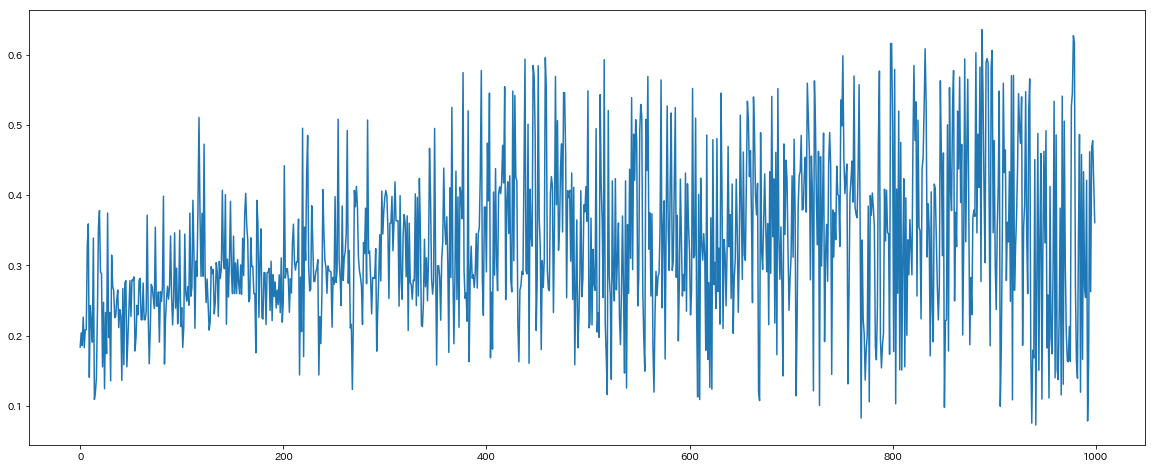

In [10]:
x = range(len(field.agent_list))
y = dens
plt.figure(figsize=(20, 8))
plt.plot(x, y);

In [11]:
time_dens = [0] * field.worldtime
time_dens_count = [0] * field.worldtime
for i,agent in enumerate(field.agent_list):
    for j in range(agent.survival_time):
        time_dens[j] += agent.log_dens[j]
        time_dens_count[j] += 1
        
time_dens_ave = [time_dens[i] / time_dens_count[i] if time_dens_count[i]!= 0 else 0 for i in range(len(time_dens))]
pickle_dump(time_dens_ave,'/home/wakaizumi/program/M1/道路ネットワーク/pickle/19/time_dens_ave4.pickle')

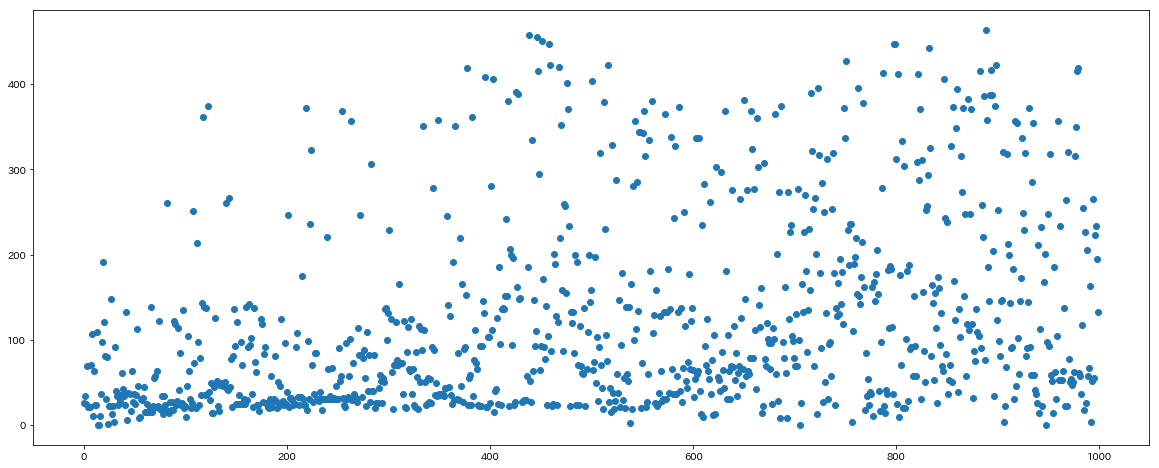

In [13]:
DENS = 0.5
high_dens_list = []
for i,agent in enumerate(field.agent_list):
    high_dens_list.append(sum(1 for x in agent.log_dens if x>DENS))

pickle_dump(high_dens_list,'/home/wakaizumi/program/M1/道路ネットワーク/pickle/19/high_dens4.pickle')
    
x = range(1000)
y = high_dens_list
plt.figure(figsize=(20, 8))
plt.plot(x, y, marker = "o", linestyle = "");